<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Analytical-results-for-test-1(Section-6-&amp;-7)" data-toc-modified-id="Analytical-results-for-test-1(Section-6-&amp;-7)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analytical results for test 1(Section 6 &amp; 7)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#sobol-indices" data-toc-modified-id="sobol-indices-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>sobol indices</a></span></li><li><span><a href="#Quantile-based-measures" data-toc-modified-id="Quantile-based-measures-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Quantile-based measures</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-2.0.6"><span class="toc-item-num">2.0.6&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></li><li><span><a href="#The-brute-force-estimator" data-toc-modified-id="The-brute-force-estimator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The brute force estimator</a></span></li><li><span><a href="#DLR-MC-estimator(section-4-&amp;-7)" data-toc-modified-id="DLR-MC-estimator(section-4-&amp;-7)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DLR MC estimator(section 4 &amp; 7)</a></span><ul class="toc-item"><li><span><a href="#MCS_quantile-function" data-toc-modified-id="MCS_quantile-function-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>MCS_quantile function</a></span></li><li><span><a href="#Numerical-tests" data-toc-modified-id="Numerical-tests-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Numerical tests</a></span><ul class="toc-item"><li><span><a href="#Test-1:-independent-normal-(p43)" data-toc-modified-id="Test-1:-independent-normal-(p43)-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Test 1: independent normal (p43)</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.2.1.1"><span class="toc-item-num">4.2.1.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.2.1.2"><span class="toc-item-num">4.2.1.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Build-base-sample" data-toc-modified-id="Build-base-sample-4.2.1.3"><span class="toc-item-num">4.2.1.3&nbsp;&nbsp;</span>Build base sample</a></span></li><li><span><a href="#Get-measures" data-toc-modified-id="Get-measures-4.2.1.4"><span class="toc-item-num">4.2.1.4&nbsp;&nbsp;</span>Get measures</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4.2.1.5"><span class="toc-item-num">4.2.1.5&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Fig.-1.----(p38)" data-toc-modified-id="Fig.-1.----(p38)-4.2.1.6"><span class="toc-item-num">4.2.1.6&nbsp;&nbsp;</span>Fig. 1.    (p38)</a></span></li></ul></li><li><span><a href="#Test-2:--independent-exponential-(p45)" data-toc-modified-id="Test-2:--independent-exponential-(p45)-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Test 2:  independent exponential (p45)</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.2.2.1"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.2.2.2"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-4.2.2.3"><span class="toc-item-num">4.2.2.3&nbsp;&nbsp;</span>pdf of output</a></span></li><li><span><a href="#Get-measures" data-toc-modified-id="Get-measures-4.2.2.4"><span class="toc-item-num">4.2.2.4&nbsp;&nbsp;</span>Get measures</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4.2.2.5"><span class="toc-item-num">4.2.2.5&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Fig.-3-(p39)" data-toc-modified-id="Fig.-3-(p39)-4.2.2.6"><span class="toc-item-num">4.2.2.6&nbsp;&nbsp;</span>Fig. 3 (p39)</a></span></li></ul></li><li><span><a href="#Test-3:--independent-uniform-(p45)" data-toc-modified-id="Test-3:--independent-uniform-(p45)-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Test 3:  independent uniform (p45)</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.2.3.1"><span class="toc-item-num">4.2.3.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.2.3.2"><span class="toc-item-num">4.2.3.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-4.2.3.3"><span class="toc-item-num">4.2.3.3&nbsp;&nbsp;</span>pdf of output</a></span></li><li><span><a href="#Get-measures" data-toc-modified-id="Get-measures-4.2.3.4"><span class="toc-item-num">4.2.3.4&nbsp;&nbsp;</span>Get measures</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4.2.3.5"><span class="toc-item-num">4.2.3.5&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Fig.-4-(p40)" data-toc-modified-id="Fig.-4-(p40)-4.2.3.6"><span class="toc-item-num">4.2.3.6&nbsp;&nbsp;</span>Fig. 4 (p40)</a></span></li></ul></li><li><span><a href="#Test-4:-correlated-multivariate-normal" data-toc-modified-id="Test-4:-correlated-multivariate-normal-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Test 4: correlated multivariate normal</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.2.4.1"><span class="toc-item-num">4.2.4.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.2.4.2"><span class="toc-item-num">4.2.4.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-4.2.4.3"><span class="toc-item-num">4.2.4.3&nbsp;&nbsp;</span>pdf of output</a></span></li><li><span><a href="#Get-measures" data-toc-modified-id="Get-measures-4.2.4.4"><span class="toc-item-num">4.2.4.4&nbsp;&nbsp;</span>Get measures</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4.2.4.5"><span class="toc-item-num">4.2.4.5&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Fig.-5.--(p42)" data-toc-modified-id="Fig.-5.--(p42)-4.2.4.6"><span class="toc-item-num">4.2.4.6&nbsp;&nbsp;</span>Fig. 5.  (p42)</a></span></li></ul></li></ul></li><li><span><a href="#Practical-case-study(Section-8)" data-toc-modified-id="Practical-case-study(Section-8)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Practical case study(Section 8)</a></span><ul class="toc-item"><li><span><a href="#Case-study-1.-Roof-Truss-structure(need-check)" data-toc-modified-id="Case-study-1.-Roof-Truss-structure(need-check)-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Case study 1. Roof Truss structure(need check)</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.3.1.1"><span class="toc-item-num">4.3.1.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.3.1.2"><span class="toc-item-num">4.3.1.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Build-base-sample" data-toc-modified-id="Build-base-sample-4.3.1.3"><span class="toc-item-num">4.3.1.3&nbsp;&nbsp;</span>Build base sample</a></span></li><li><span><a href="#Get-measures" data-toc-modified-id="Get-measures-4.3.1.4"><span class="toc-item-num">4.3.1.4&nbsp;&nbsp;</span>Get measures</a></span></li><li><span><a href="#Fig.-7-（p44)" data-toc-modified-id="Fig.-7-（p44)-4.3.1.5"><span class="toc-item-num">4.3.1.5&nbsp;&nbsp;</span>Fig. 7 （p44)</a></span></li></ul></li></ul></li></ul></li></ul></div>

To do:

- **main function**
    - Which type of function outputs should be? np.array(temporarily) or pandas dataframe?

- **Sampling**

    - <a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-3.2.2.3"><span class="toc-item-num">3.2.2.3&nbsp;&nbsp;</span>pdf of output</a>   
        For test 2, the inputs of the model follows the exponential distribution and the PDF of the output Y should be a Laplace distribution shown in Fig.3(a). I generate exponential distributed inputs with $\lambda=1$, and the PDF of the output Y turns out to be a Laplace distribution but the sacle(x axis) is different from the desired one( Fig.3(a)). I tried to adjust `scale` keyword of the code `A_2 = expon.ppf(X02, loc=0, scale=1)` which is used to generate exponential distributed sample from uniform distributed sample, but the results are still not ideal. 
        
    - <a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-3.2.4.3"><span class="toc-item-num">3.2.4.3&nbsp;&nbsp;</span>pdf of output</a>   
        <a href="#Fig.-5.--(p42)" data-toc-modified-id="Fig.-5.--(p42)-3.2.4.6"><span class="toc-item-num">3.2.4.6&nbsp;&nbsp;</span>Fig. 5.  (p42)</a>   
        For test 4, the inputs for the model are correlated multivarate distributed. The multivariate normal sample I generate leads to a deviatation of quantile measures compared to the desired results(fig. 5). 
- **Test for function**
    - How to check the accurancy of test 2-4? There is no analytical values provided in paper.

# Introduction 


New global sensitivity measures based on quantiles of the output has been introduced by [Kucherenko et al.(2019)](https://www.sciencedirect.com/science/article/abs/pii/S0951832016304574) in which $\alpha$th quantiles are the functions of interest. This notebook reproduces the numerical test results of the paper. 

In [1]:
import numpy as np
import chaospy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,uniform,expon
# from temfpy.uncertainty_quantification import simple_linear_function

from numpy.testing import assert_almost_equal

# Use kucherenko_indice function written by Tim to get the numerical results of sobol indices.
from kucherenko import kucherenko_indices 

# Analytical results for test 1(Section 6 & 7)

For **linear model with normally distributed variables**, analytical values of sensitivity indices can be found and used as benchmarks for verification of numerical estimates. 

### Parameters

In [41]:
# mean and covariance
mean_1 = np.array([1, 3, 5, 7])
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

sd_1 = np.sqrt(np.diag(cov_1))

# dimension 
dim_1 = 4

# range of alpha
dalp = (0.98 - 0.02) / 30   # 0.032
alp = np.arange(0.02, 0.98 + dalp, dalp) 
n_params = 4

### Objective function
$$Y=x_1+x_2+x_3+x_4$$

In [3]:
# objective function (Eq.32)
a_1 = np.array([1, 1, 1, 1])

def objfun1(x):
    result = a_1[0] * x[:, 0] + a_1[1] * x[:, 1] + a_1[2] * x[:, 2] + a_1[3] * x[:, 3]
    return result

### sobol indices

$$
S_i=S_i^{tot}=\frac{a_i^2 \sigma_i^2}{\sum_{j=1}^d a_j^2 \sigma_j^2}
$$

In [4]:
# sobol indices
S_i = []
for i in range(dim_1):
    S_i_i = a_1[0] ** 2 * cov_1[i, i] / np.trace(np.power(a_1, 2) * cov_1)
    S_i.append(S_i_i)

S_i = np.hstack(S_i)

print(S_i)

# for plot convinence
S_i_plot = np.tile(S_i, (len(alp), 1))

[0.07407407 0.16666667 0.2962963  0.46296296]


### Quantile-based measures
$q_i^{(2)}(\alpha)$ of linear model with normally distributed variables is obtained from following formula:

$$
q_i^{(2)}(\alpha)=a_i^2 \sigma_i^2+[\Phi^{-1}(\alpha)]^2 \left(\sqrt{\sum_{i=1}^d a_i^2 \sigma_i^2}-\sqrt{\sum_{j=1,j \ne i}^d a_j^2 \sigma_j^2} \right)^2
\tag{30}
$$

In [5]:
# inverse error function
phi_inv = norm.ppf(alp)

# q_2: PDF of the output Y(Eq.30)
q_2 = []
for a in range(len(alp)):
    q_2_a = []
    for i in range(dim_1):
        q_2_i = cov_1[i,i] + phi_inv[a] ** 2 * (np.sqrt(np.trace(cov_1)) - np.sqrt(sum(cov_1[j, j] for j in range(dim_1) if j != i))) ** 2
        q_2_a.append(q_2_i)
    q_2.append(q_2_a)
    
q_2 = np.vstack(q_2).reshape((len(alp), dim_1))
q_2

array([[ 1.08114318,  2.68226953,  5.4783546 , 10.31452679],
       [ 1.05084778,  2.52087855,  4.92640012,  8.79700604],
       [ 1.03656545,  2.44479306,  4.66618903,  8.08159246],
       [ 1.02748243,  2.39640559,  4.50070468,  7.62661666],
       [ 1.02101025,  2.36192673,  4.38278756,  7.30242023],
       [ 1.0161193 ,  2.33587142,  4.29367881,  7.05742834],
       [ 1.01229689,  2.31550854,  4.2240381 ,  6.86596106],
       [ 1.00925213,  2.29928838,  4.16856543,  6.71344681],
       [ 1.00680533,  2.28625367,  4.12398695,  6.59088457],
       [ 1.0048389 ,  2.275778  ,  4.08816034,  6.49238438],
       [ 1.00327286,  2.26743533,  4.05962854,  6.41394024],
       [ 1.00205157,  2.2609292 ,  4.03737768,  6.35276465],
       [ 1.00113604,  2.25605198,  4.02069767,  6.3069053 ],
       [ 1.0004994 ,  2.25266043,  4.00909861,  6.27501535],
       [ 1.00012404,  2.2506608 ,  4.00225994,  6.25621338],
       [ 1.        ,  2.25      ,  4.        ,  6.25      ],
       [ 1.00012404,  2.

In [6]:
# warning: works only in this case
q_1 = np.sqrt(q_2)

In [7]:
# Q_2: normalized quantile based sensitivity measure 2.(Eq.14)
Q_2 = []
for a in range(len(alp)):
    Q_2_a = []
    for i in range(dim_1):
        Q_2_i = q_2[a, i] / sum(q_2[a])
        Q_2_a.append(Q_2_i)
    Q_2.append(Q_2_a)

Q_2 = np.hstack(Q_2).reshape((len(alp), dim_1))

In [8]:
Q_2[15]

array([0.07407407, 0.16666667, 0.2962963 , 0.46296296])

In [9]:
# Q_1: normalized quantile based sensitivity measure 
Q_1 = []
for a in range(len(alp)):
    Q_1_a = []
    for i in range(dim_1):
        Q_1_i = q_1[a, i] / sum(q_1[a])
        Q_1_a.append(Q_1_i)
    Q_1.append(Q_1_a)

Q_1 = np.hstack(Q_1).reshape((len(alp), dim_1))

In [10]:
Q_1 

array([[0.12634401, 0.19900512, 0.28440557, 0.39024531],
       [0.13145182, 0.2035976 , 0.28461746, 0.38033312],
       [0.13423404, 0.20615096, 0.2848036 , 0.37481139],
       [0.13615517, 0.20793477, 0.28496217, 0.37094789],
       [0.13760513, 0.20929208, 0.28509841, 0.36800438],
       [0.13874958, 0.21036999, 0.28521614, 0.3656643 ],
       [0.13967517, 0.21124598, 0.28531801, 0.36376083],
       [0.14043309, 0.21196607, 0.28540589, 0.36219495],
       [0.14105599, 0.21255973, 0.28548115, 0.36090313],
       [0.14156585, 0.21304691, 0.28554479, 0.35984245],
       [0.14197796, 0.21344149, 0.28559759, 0.35898297],
       [0.14230316, 0.21375337, 0.28564011, 0.35830336],
       [0.14254917, 0.21398962, 0.28567278, 0.35778844],
       [0.14272139, 0.21415514, 0.2856959 , 0.35742756],
       [0.14282337, 0.21425322, 0.2857097 , 0.35721371],
       [0.14285714, 0.21428571, 0.28571429, 0.35714286],
       [0.14282337, 0.21425322, 0.2857097 , 0.35721371],
       [0.14272139, 0.21415514,

### Test

In [11]:
# Theorem 1: compare with sobol indice at alpha=0.5
assert_almost_equal(Q_2[15], S_i, decimal=5)

### Plot

Text(0, 0.5, 'Measures')

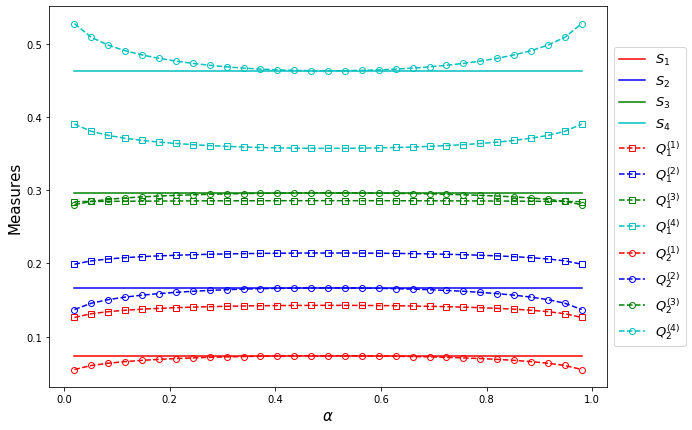

In [12]:


plt.figure(figsize=(10,7))

plt.plot(alp, S_i_plot[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_plot[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_plot[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_plot[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp, Q_1[:, 0], 'rs--',label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 1], 'bs--',label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 2], 'gs--',label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 3], 'cs--',label=r'$Q_1^{(4)}$', markerfacecolor='none')

plt.plot(alp, Q_2[:, 0], 'ro--',label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 1], 'bo--',label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 3], 'co--',label=r'$Q_2^{(4)}$', markerfacecolor='none')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

# The brute force estimator

Genrerate 2 independent sample points

In [75]:
# simulate 200 times
# N=200
# myseedlist = np.arange(0, 1000, 5).astype(int)  

# # simulate 500 times
# N = 500
# myseedlist = np.linspace(0, 5000, num=500, endpoint=False).astype(int)

# # simulate 1000 times
# N = 1000
# myseedlist = np.arange(0, 10000, 10).astype(int)  

# # simulate 2**12 times
N = 2**12
myseedlist = np.linspace(0, 2**12*10, num=2**12, endpoint=False).astype(int)

In [76]:
def jth_ind_points(myseed):
    np.random.seed(myseed)
    draws = np.random.uniform(size=(N, 2*n_params))   
    u_j = draws[0:, :n_params]
    x_j = norm.ppf(u_j, mean_1, sd_1)
        
    u_prime_j = draws[0:, n_params:]
    x_prime_j = norm.ppf(u_prime_j, mean_1, sd_1)
    
    conditional_sample_j = np.zeros((4,N,4)) # 4*N*4
    
    for i in range(4): 
        conditional_sample_j[i] = x_j
        conditional_sample_j[i, :, i] = x_prime_j[:,i]
        
    return x_j, conditional_sample_j 

Run N times of sampling

In [77]:
x = np.zeros((N,N,4)) # N*N*1
conditional_sample = np.zeros((N,4,N,4))  # N*d*N*d

for j in range(N):
    x[j] = jth_ind_points(myseedlist[j])[0]
    conditional_sample[j] =  jth_ind_points(myseedlist[j])[1]

Model output and quantiles

In [78]:
y_1 = np.zeros((N,N,1)) # N*N*1
y_1_asc = np.zeros((N,N,1)) # N*N*1
qy_alp1 = np.zeros((N,len(alp),1)) # N*31*1

for j in range(N):
    y_1[j] = np.vstack(objfun1(x[j]))
    y_1_asc[j] = np.sort(y_1[j], axis=0)
    # conditioanl q_y(alp)
    for pp in range(len(alp)):
        qy_alp1[j, pp] = y_1_asc[j][
            (np.floor(alp[pp] * N)).astype(int)
        ]  # quantiles corresponding to alpha

In [79]:
y_2 = np.zeros((N,4,N,1))  # N*d*N*1
y_2_asc = np.zeros((N,4,N,1))  # N*d*N*1
qy_alp2 = np.zeros((N,4,len(alp),1))   # N*4*31*1

# Equation 21(b) & 23
for j in range(N):
    for i in range(4):
        # values of conditional outputs
        y_2[j, i] = np.vstack(objfun1(conditional_sample[j,i]))
        y_2_asc[j, i] = np.sort(y_2[j,i], axis=0)
        # conditioanl q_y(alp)
        for pp in range(len(alp)):
            qy_alp2[j, i, pp] = y_2_asc[j, i][
                (np.floor(alp[pp] * N)).astype(int)
            ]  # quantiles corresponding to alpha

quantile measures

In [80]:
# """Compute MC/QMC estimators of quantile based measures."""
# initialization
q1_alp = np.zeros((4,len(alp),1)) # d*31*1
q2_alp = np.zeros((4,len(alp),1)) # d*31*1
delt = np.zeros((N,4,len(alp),1)) # N*d*31*1

# Equation 24 & 25
for j in range(N):
    delt[j] = qy_alp2[j] - qy_alp1[j]  # delt
    for i in range(n_params):
        for pp in range(len(alp)):
            q1_alp[i,pp] = np.mean(np.absolute(delt[:,i,pp]))  # |delt|
            q2_alp[i,pp] = np.mean(delt[:,i,pp] ** 2)  # (delt)^2

In [81]:
# """Compute MC/QMC estimators of nomalized quantile based measures."""
q1 = np.zeros(len(alp))
q2 = np.zeros(len(alp))
nomalized_q1_alp = np.zeros((n_params, len(alp)))
nomalized_q2_alp = np.zeros((n_params, len(alp)))

# Equation 13 & 14
for i in range(n_params):
    q1 = q1_alp[0]+q1_alp[1]+q1_alp[2]+q1_alp[3]
    q2 = q2_alp[0]+q2_alp[1]+q2_alp[2]+q2_alp[3]
    for pp in range(len(alp)):
        nomalized_q1_alp[i, pp] = q1_alp[i, pp] / q1[pp]
        nomalized_q2_alp[i, pp] = q2_alp[i, pp] / q2[pp]

Compare with true values

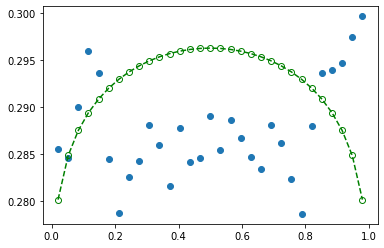

In [82]:
# comapre with true value of nomalized_q2_alp for i=3
%matplotlib inline
plt.figure() 
# plot simulation results as dots: 
plt.plot(alp, nomalized_q2_alp[2], 'o') 
# and plot the true result as a line: 
plt.plot(alp, Q_2[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')

Text(0, 0.5, 'Measures')

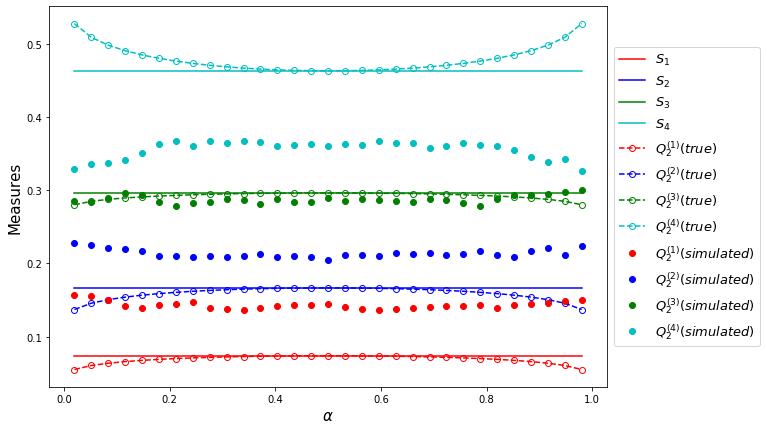

In [83]:
plt.figure(figsize=(10,7))

plt.plot(alp, S_i_plot[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_plot[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_plot[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_plot[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp, Q_2[:, 0], 'ro--',label=r'$Q_2^{(1)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 1], 'bo--',label=r'$Q_2^{(2)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 2], 'go--',label=r'$Q_2^{(3)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 3], 'co--',label=r'$Q_2^{(4)}(true)$', markerfacecolor='none')

plt.plot(alp, nomalized_q2_alp[0], 'ro',label=r'$Q_2^{(1)}(simulated)$')
plt.plot(alp, nomalized_q2_alp[1], 'bo',label=r'$Q_2^{(2)}(simulated)$')
plt.plot(alp, nomalized_q2_alp[2], 'go',label=r'$Q_2^{(3)}(simulated)$')
plt.plot(alp, nomalized_q2_alp[3], 'co',label=r'$Q_2^{(4)}(simulated)$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

Text(0, 0.5, 'Measures')

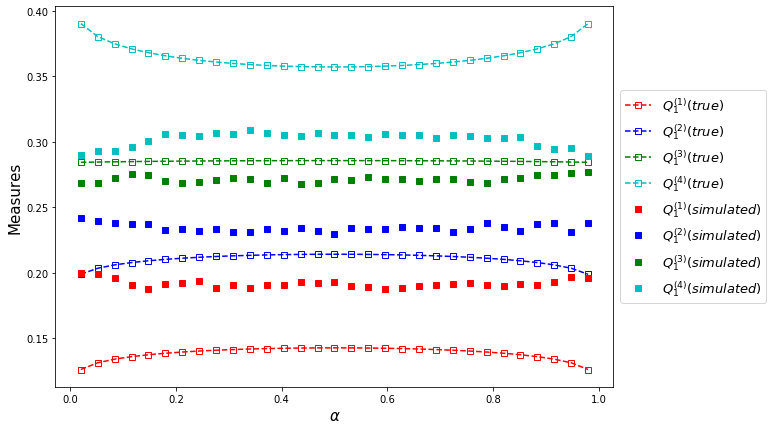

In [84]:
plt.figure(figsize=(10,7))

plt.plot(alp, Q_1[:, 0], 'rs--',label=r'$Q_1^{(1)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 1], 'bs--',label=r'$Q_1^{(2)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 2], 'gs--',label=r'$Q_1^{(3)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 3], 'cs--',label=r'$Q_1^{(4)}(true)$', markerfacecolor='none')

plt.plot(alp, nomalized_q1_alp[0], 'rs', label=r'$Q_1^{(1)}(simulated)$')
plt.plot(alp, nomalized_q1_alp[1], 'bs', label=r'$Q_1^{(2)}(simulated)$')
plt.plot(alp, nomalized_q1_alp[2], 'gs', label=r'$Q_1^{(3)}(simulated)$')
plt.plot(alp, nomalized_q1_alp[3], 'cs', label=r'$Q_1^{(4)}(simulated)$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

# DLR MC estimator(section 4 & 7)


**Step 1: Sampling**  (inverse transform sampling) 

1. Generate $N$ points $x^{(j)},j=1,2, \dots, N$ from the joint PDF $\rho(x_1, \dots, x_d)$
    1. Generate N points of n-dimensional **uniform distributed** sample
    1. Transform uniform draw into a **standard normal** draw
    1. Transform standard normal draw into assigned joint PDF $\rho(x_1, \dots, x_d)$

1. Construct conditional sample: 
    1. Sort base sample set $x^{(j)},j=1,2, \dots, N$ in ascending order with respect to the values of $x_i$ and subdivided in **M equally populated partitions (bins)** with $N_m=N/M$ points in each bin $(M < N)$
    1. Within each bin a mixed $\{(x_{\sim i}^j,x_{i}^{'(j)})\}$ set distributed according to a conditional PDF $\rho(x_1, \dots, x_d|x_i=X_i^{'(j)})$  where $(x_{\sim i}^j,x_i^{'(j)})=(x_1^j, \dots, x_i^{'(j)}, \dots, x_d^j)$ 

**Step 2: Build a CDF  of output** 

1. CDF **$F_Y(y)$** of the out put $Y$
$$
F_Y^{(N)}(y)=\frac{1}{N} \sum_{l=1}^N I(Y(x_1^l, \dots , x_d^l)<y)
\tag{21a}
$$
1. Within each bin the CDF **$F_{Y|x_i}(y)$** of the output conditional on the input variable $x_i$ being fixed at $x_i=X_i^l,l=1,\dots, N_m$ is estimated as
$$
F_{Y \mid X_i}^{(N_m)}(y)=\frac{1}{N_m} \sum_{l=1}^{N_m} I(Y(x_1^l, \dots , x_i^l = X_i^l, \dots , x_d^l)<y)
\tag{26}
$$

**Step 3: Get quantiles of output**

1. Unconditional quantile 
    $$
    q_Y^{(N)}(\alpha)=[F_Y^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_Y^{(N)}(Y \le y) \ge \alpha \right\}
    \tag{22}
    $$
1. Conditional quantile 
    $$
    q_{Y \mid X_i}^{(N)}(\alpha)=[F_{Y \mid X_i}^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_{Y \mid X_i}^{(N)}(Y \le y \mid x_i=X_i) \ge \alpha \right\}
    \tag{23}
    $$

**Step 4: MC/QMC estimates of quantiles**

1. Quantile based measures
    $$
\tilde{q_i}^{(1)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \mid q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \mid
    \tag{27}
    $$

    $$
\tilde{q_i}^{(2)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \left( q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \right)^2
    \tag{28}
    $$
1. Nomalized quantile based measures
$$
Q_i^{(1)}(\alpha)=\frac{\bar{q}_i^{(1)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(1)}(\alpha)}
\tag{13}
$$   

$$
Q_i^{(2)}(\alpha)=\frac{\bar{q}_i^{(2)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(2)}(\alpha)}
\tag{14}
$$



## MCS_quantile function

In [13]:
# Total number of sample points
N = 2**13 # 8192

# number of conditional samples
M = 64

In [14]:
"""Calculate quantile based global sensitivity measures.

This module contains functions to calculate global sensitivity measures based on
quantiles of the output introduced by Kucherenko et al.(2019).

TODO:
    - Correct the sampling methods for exponential distribution and multivariate distribution.

"""
import chaospy as cp
import numpy as np
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform


def mcs_quantile(
    func, n_params, loc, scale, dist_type, n_draws=2 ** 13, m=64, skip=0,
):
    r"""Compute Monte Carlo estimators of quantile based global sensitivity measures.

    This function implements the Double loop reordering(DLR) approach described in
    Section 4.2 of [K2019]_.

    Parameters
    ----------
    func : callable
        Objective function to calculate the quantile-based measures. Must be broadcastable.

    n_params : int
        Number of parameters of objective function.

    loc : np.ndarray or float
        The location(`loc`) keyword passed to `scipy.stats.norm`_ function to shift the
        location of "standardized" distribution. Specifically, for normal distribution
        it specifies the mean with the length of `n_params`.

        .. _scipy.stats.norm: https://docs.scipy.org/doc/scipy/reference/generated/
            _scipy.stats.norm.html

    scale : np.ndarray or float
        The `scale` keyword passed to `scipy.stats.norm`_ function to adjust the scale of
        "standardized" distribution. Specifically, for normal distribution it specifies
        the covariance matrix of shape (n_params, n_params).

    dist_type : str
        The distribution type of input. Options are "Normal", "Exponential" and "Uniform".

    n_draws : int
        Number of sampled points. This will later turn into the number of Monte Carlo draws.
        Accroding to [K2017]_, to preserve the uniformity properties `n_draws` should always be
        equal to :math:`n_draws = 2^p`, where :math:`p` is an integer. Default is :math:`2^13`.

    m : int
        Number of conditional samples. It was suggested in [K2017]_ to use as a
        "rule of thumb" :math:`m \sim \sqrt{n_draws}`. Default is `64`.

    skip : int
        Number of values to skip of Sobol sequence. Default is `0`.

    Returns
    -------
    q1_alp : np.ndarray
        Quantile based measure. Shape has the form (len(alp), n_params).

    q2_alp : np.ndarray
        Quantile based measure. Shape has the form (len(alp), n_params).

    nomalized_q1_alp : np.ndarray
        Nomalized quantile based measure. Shape has the form (len(alp), n_params).

    nomalized_q2_alp : np.ndarray
        Nomalized quantile based measure. Shape has the form (len(alp), n_params).

    References
    ----------
    .. [K2019] S. Kucherenko, S. Song, L. Wang. Quantile based global
        sensitivity measures, Reliab. Eng. Syst. Saf. 185 (2019) 35–48.

    .. [K2017] Kucherenko S, Song S. Different numerical estimators
        for main effect global sensitivity indices. Reliab Eng Syst
        Saf 2017;165:222–38.
    """
    # range of alpha
    dalp = (0.98 - 0.02) / 30
    alp = np.arange(0.02, 0.98 + dalp, dalp)  # len(alp) = 31

    # Get quantile based measures
    q1_alp, q2_alp = _quantile_based_measures(
        func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
    )

    # Get nomalized quantile based measures
    nomalized_q1_alp, nomalized_q2_alp = _nomalized_quantile_based_measures(
        func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
    )

    return q1_alp, q2_alp, nomalized_q1_alp, nomalized_q2_alp


def _get_unconditional_sample(
    n_params, loc, scale, dist_type, n_draws, m, skip=0,
):
    """Generate a base sample set according to joint PDF."""
    # Generate uniform distributed sample
    u_1 = cp.generate_samples(order=n_draws + skip, domain=n_params, rule="S").T
    u_2 = u_1[skip:, :n_params]
    unconditional_sample = np.zeros((n_draws, n_params))

    # Transform uniform draw into assigned joint PDF
    if dist_type == "Normal":
        z = norm.ppf(u_2)
        cholesky = np.linalg.cholesky(scale)
        unconditional_sample = loc + cholesky.dot(z.T).T
    elif dist_type == "Exponential":
        unconditional_sample = expon.ppf(u_2, loc, scale)
    elif dist_type == "Uniform":
        unconditional_sample = uniform.ppf(u_2, loc, scale)
    else:
        raise NotImplementedError

    return unconditional_sample


def _get_conditional_sample(
    n_params, loc, scale, dist_type, n_draws, m, skip,
):
    """Generate a conditional sample set from the base sample set."""
    unconditional_sample = _get_unconditional_sample(
        n_params, loc, scale, dist_type, n_draws, m, skip,
    )
    conditional_bin = unconditional_sample[:m]
    # conditional sample matrix with shape of (m, n_params, n_draws, n_params)
    conditional_sample = np.array(
        [[np.zeros((n_draws, n_params)) for x in range(n_params)] for z in range(m)],
        dtype=np.float64,
    )

    for i in range(n_params):
        for j in range(m):
            conditional_sample[j, i] = unconditional_sample
            conditional_sample[j, i, :, i] = conditional_bin[j, i]

    return conditional_sample


def _unconditional_q_y(
    func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
):
    """Calculate quantiles of outputs with unconditional sample set as inputs."""
    unconditional_sample = _get_unconditional_sample(
        n_params, loc, scale, dist_type, n_draws, m, skip,
    )

    # Equation 26 & 23
    y_1 = func(unconditional_sample)  # values of outputs
    y_1_asc = np.sort(y_1)  # reorder in ascending order
    q_index = (np.floor(alp * n_draws)).astype(int)
    qy_alp1 = y_1_asc[q_index]  # quantiles corresponding to alpha

    return qy_alp1


def _conditional_q_y(
    func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
):
    """Calculate quantiles of outputs with conditional sample set as inputs."""
    conditional_sample = _get_conditional_sample(
        n_params, loc, scale, dist_type, n_draws, m, skip,
    )  # shape(m, n_params, n_draws, n_params)

    # initialize values of conditional outputs.
    y_2 = np.array(
        [[np.zeros((n_draws, 1)) for x in range(n_params)] for z in range(m)],
        dtype=np.float64,
    )  # shape(n_draws, n_params, n_draws, 1)
    y_2_asc = np.array(
        [[np.zeros((n_draws, 1)) for x in range(n_params)] for z in range(m)],
        dtype=np.float64,
    )
    # initialize quantile of conditional outputs.
    qy_alp2 = np.array(
        [[np.zeros((len(alp), m)) for x in range(n_params)] for z in range(1)],
        dtype=np.float64,
    )  # shape(1, n_params, len(alp), m)

    # Equation 26 & 23
    for i in range(n_params):
        for j in range(m):
            # values of conditional outputs
            y_2[j, i] = np.vstack(func(conditional_sample[j, i]))
            y_2[j, i].sort(axis=0)
            y_2_asc[j, i] = y_2[j, i]  # reorder in ascending order
            # conditioanl q_y(alp)
            for pp in range(len(alp)):
                qy_alp2[0, i, pp, j] = y_2_asc[j, i][
                    (np.floor(alp[pp] * n_draws)).astype(int)
                ]  # quantiles corresponding to alpha
    return qy_alp2


def _quantile_based_measures(
    func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
):
    """Compute MC/QMC estimators of quantile based measures."""
    qy_alp1 = _unconditional_q_y(
        func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
    )
    qy_alp2 = _conditional_q_y(
        func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
    )

    # initialization
    q1_alp = np.zeros((len(alp), n_params))
    q2_alp = np.zeros((len(alp), n_params))
    delt = np.array(
        [[np.zeros((1, m)) for x in range(n_params)] for z in range(1)],
        dtype=np.float64,
    )

    # Equation 27 & 28
    for i in range(n_params):
        for pp in range(len(alp)):
            delt[0, i] = qy_alp2[0, i, pp, :] - qy_alp1[pp]  # delt
            q1_alp[pp, i] = np.mean(np.absolute(delt[0, i]))  # |delt|
            q2_alp[pp, i] = np.mean(delt[0, i] ** 2)  # (delt)^2

    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(
    func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
):
    """Compute MC/QMC estimators of nomalized quantile based measures."""
    q1_alp, q2_alp = _quantile_based_measures(
        func, n_params, loc, scale, dist_type, alp, n_draws, m, skip,
    )

    # initialize quantile measures arrays.
    q1 = np.zeros(len(alp))
    q2 = np.zeros(len(alp))
    nomalized_q1_alp = np.zeros((len(alp), n_params))
    nomalized_q2_alp = np.zeros((len(alp), n_params))

    # Equation 13 & 14
    for pp in range(len(alp)):
        q1[pp] = np.sum(q1_alp[pp, :])
        q2[pp] = np.sum(q2_alp[pp, :])
        for i in range(n_params):
            nomalized_q1_alp[pp, i] = q1_alp[pp, i] / q1[pp]
            nomalized_q2_alp[pp, i] = q2_alp[pp, i] / q2[pp]

    return nomalized_q1_alp, nomalized_q2_alp

## Numerical tests

### Test 1: independent normal (p43)
   $Y=a_1x_1+a_2x_2+a_3x_3+a_4x_4$, where $x_i \sim N(\mu_i,\sigma^2)$ 

#### Objective function

In [15]:
# objective function
a_1 = [1, 1, 1, 1]
def objfun1(x):
    result = a_1[0] * x[:, 0] + a_1 [1] * x[:, 1] + a_1[2] * x[:, 2] + a_1[3] * x[:, 3]
    return result

#### Parameters

In [16]:
# mean for normal distribution
miu_1 = np.array([1, 3, 5, 7])

# standard deviation for normal distribution
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

sd = np.sqrt(np.diag(cov_1))

# dimension of inputs
dim_1 = np.size(miu_1) # 4

#### Build base sample

#### Get measures

In [17]:
q1_alp_1, q2_alp_1, Q1_alp_1, Q2_alp_1 = mcs_quantile(objfun1, dim_1, miu_1, cov_1, "Normal")

In [18]:
Q2_alp_1[15]

array([0.07832814, 0.16496843, 0.2929783 , 0.46372513])

#### Test

In [21]:
# Q1_alp_1: comapre with analytical results

# for decimal=2
assert_almost_equal(Q_1, Q1_alp_1, decimal=2) # pass

# for decimal=3
# assert_almost_equal(Q_1, Q1_alp_1, decimal=3)  # fail

In [22]:
# Q2_alp_1: comapre with analytical results

# for decimal=2
assert_almost_equal(Q_2, Q2_alp_1, decimal=2) # pass

# for decimal=3
# assert_almost_equal(Q_2, Q2_alp_1, decimal=3)  # fail

In [23]:
# compare Q2_alp_1 with sobol indice at alpha=0.5

# for decimal=2
assert_almost_equal(Q2_alp_1[15],S_i, decimal=2) # pass


# for decimal=3
# assert_almost_equal(Q2_alp_1[15],S_i, decimal=3)  # fail

#### Fig. 1.    (p38)
Values of $Q_i^{(1)}$ and $Q_i^{(2)}$ versus $\alpha$ and values of Sobol’ sensitivity indices. Test 1.

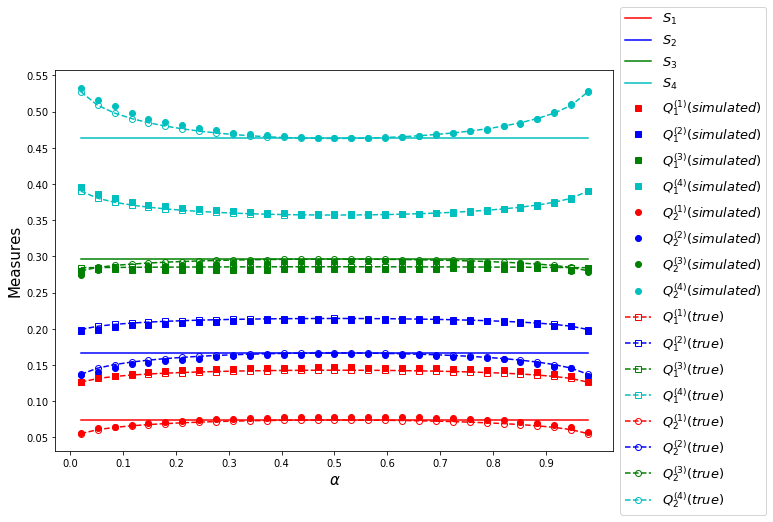

In [31]:
plt.figure(figsize=(10,7))

plt.plot(alp, S_i_plot[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_plot[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_plot[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_plot[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp,  Q1_alp_1[:, 0], 'rs', label=r'$Q_1^{(1)}(simulated)$')
plt.plot(alp,  Q1_alp_1[:, 1], 'bs', label=r'$Q_1^{(2)}(simulated)$')
plt.plot(alp,  Q1_alp_1[:, 2], 'gs', label=r'$Q_1^{(3)}(simulated)$')
plt.plot(alp,  Q1_alp_1[:, 3], 'cs', label=r'$Q_1^{(4)}(simulated)$')

plt.plot(alp, Q2_alp_1[:, 0], 'ro', label=r'$Q_2^{(1)}(simulated)$')
plt.plot(alp, Q2_alp_1[:, 1], 'bo', label=r'$Q_2^{(2)}(simulated)$')
plt.plot(alp, Q2_alp_1[:, 2], 'go', label=r'$Q_2^{(3)}(simulated)$')
plt.plot(alp, Q2_alp_1[:, 3], 'co', label=r'$Q_2^{(4)}(simulated)$')

plt.plot(alp, Q_1[:, 0], 'rs--',label=r'$Q_1^{(1)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 1], 'bs--',label=r'$Q_1^{(2)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 2], 'gs--',label=r'$Q_1^{(3)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_1[:, 3], 'cs--',label=r'$Q_1^{(4)}(true)$', markerfacecolor='none')

plt.plot(alp, Q_2[:, 0], 'ro--',label=r'$Q_2^{(1)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 1], 'bo--',label=r'$Q_2^{(2)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 2], 'go--',label=r'$Q_2^{(3)}(true)$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 3], 'co--',label=r'$Q_2^{(4)}(true)$', markerfacecolor='none')

plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0.05, 0.6, 0.05))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

plt.show()

### Test 2:  independent exponential (p45)
$Y=x_1-x_2+x_3-x_4$, where $x_i \sim Exp(\lambda=1)$


#### Objective function

In [593]:
# objective function
a_2 = [1,-1,1,-1]

def objfun2(x):
    result = a_2[0] * x[:, 0] + a_2[1] * x[:, 1] + a_2[2] * x[:, 2] + a_2[3] * x[:, 3]
    return result

#### Parameters

In [594]:
# dimension of inputs
dim_2 = np.size(a_2) # 4

#### pdf of output

In [595]:
N=2**13
skip = 0

# Generate uniform distributed sample
X02 = cp.generate_samples(order=N+skip, domain=dim_2, rule="S").T
X02 = X02[skip:, :dim_2]
    
# Transform uniform draw into exponential draw
A_2 = expon.ppf(X02, loc=0, scale=1)

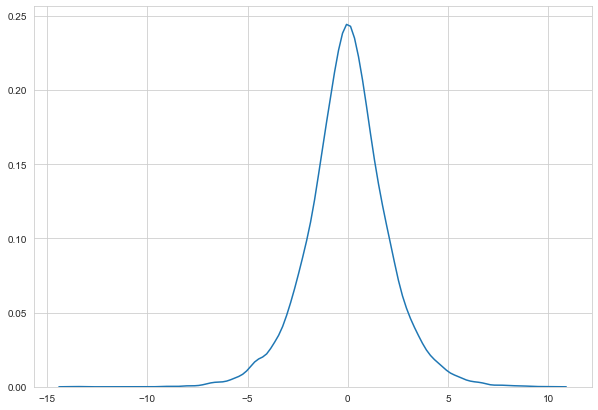

In [596]:
# The PDF of output Y(a)
Y2 = objfun2(A_2)

# fig. 3.(b)
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.kdeplot(Y2)

#### Get measures

In [597]:
q1_alp_2, q2_alp_2, Q1_alp_2, Q2_alp_2 = mcs_quantile(objfun2, dim_2, 0, 1, "Exponential")


In [598]:
(q1_alp_2, q2_alp_2, Q1_alp_2, Q2_alp_2)[3][15]

array([0.25159124, 0.24821884, 0.24939068, 0.25079923])

In [599]:
# sobol indice
S_i_2 = np.array([0.25, 0.25, 0.25, 0.25])

#### Test

In [600]:
# how?

#### Fig. 3 (p39)
The PDF of output Y (a); values of Qi(1) and Qi(2) versus α and values of Sobol ’ sensitivity indices (b). Test 2.


In [601]:
# for plot convinence
S_i_2 = np.tile(S_i_2 , (len(alp), 1))

Text(0, 0.5, 'Measures')

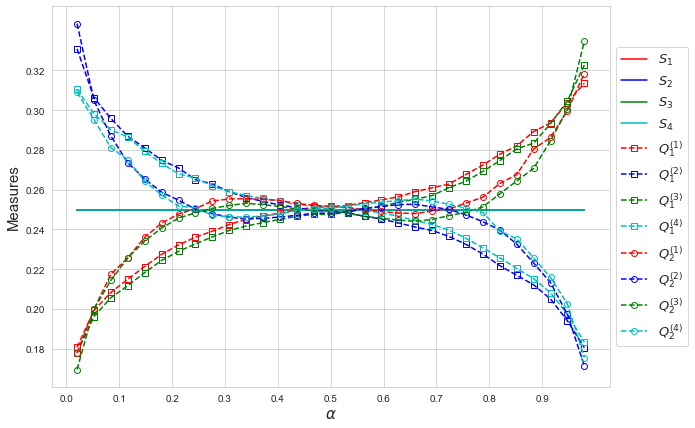

In [602]:
plt.figure(figsize=(10,7))

plt.plot(alp, S_i_2[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_2[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_2[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_2[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp,  Q1_alp_2[:, 0], 'rs--',label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp_2[:, 1], 'bs--',label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp_2[:, 2], 'gs--',label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp_2[:, 3], 'cs--',label=r'$Q_1^{(4)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp_2[:, 0], 'ro--',label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_2[:, 1], 'bo--',label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_2[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_2[:, 3], 'co--',label=r'$Q_2^{(4)}$', markerfacecolor='none')

plt.yticks(np.arange(0.18, 0.32, 0.02))
plt.xticks(np.arange(0, 1, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

### Test 3:  independent uniform (p45)
$Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$, where $x_i$ uniform distributed on the interval$[-\pi,\pi]$

#### Objective function

In [603]:
# objective function
def objfun3(x):
    result = np.sin(x[:, 0]) + 7 * np.sin(x[:, 1]) ** 2 + 0.1 * x[:, 2] ** 4 * np.sin(x[:, 0]) 
    return result

#### Parameters

In [604]:
# dimension of inputs
dim_3 = 3 

# lower bound of uniform distribution
lower_bound = -np.pi
# interval of uniform distribution
interval = 2 * np.pi

#### pdf of output

In [605]:
N=2**13
skip = 0

# Generate uniform distributed sample
A_3 = np.zeros((N,dim_3)) 
skip = 0
X03 = cp.generate_samples(order=N+skip, domain=dim_3, rule="S").T
X03 = X03[skip:, :dim_3]
    
A_3 = uniform.ppf(X03,lower_bound,interval)

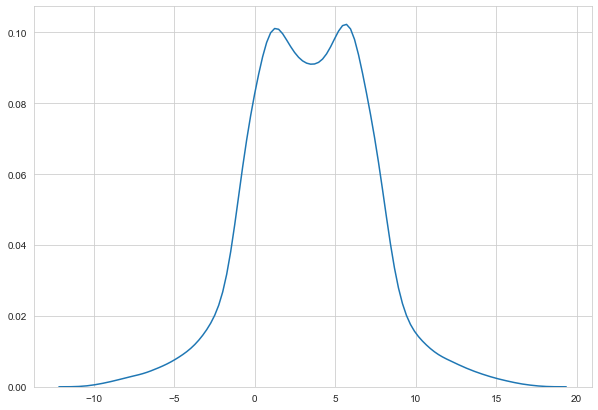

In [606]:
# The PDF of output Y(a)
Y3 = objfun3(A_3)

# fig. 3.(b)
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.kdeplot(Y3)

#### Get measures

In [607]:
q1_alp_3, q2_alp_3, Q1_alp_3, Q2_alp_3 = mcs_quantile(objfun3, dim_3, lower_bound, interval, "Uniform")

#### Test

In [608]:
# how?

#### Fig. 4 (p40)
The PDF of output Y (a); values of Qi(1) and Qi(2) versus α and values of Sobol ’ sensitivity indices (b). The Ishigami function.


In [609]:
S_i_3 = np.array([0.314, 0.442, 0.0])
S_i_3 = np.tile(S_i_3, (len(alp), 1))

Text(0, 0.5, 'Measures')

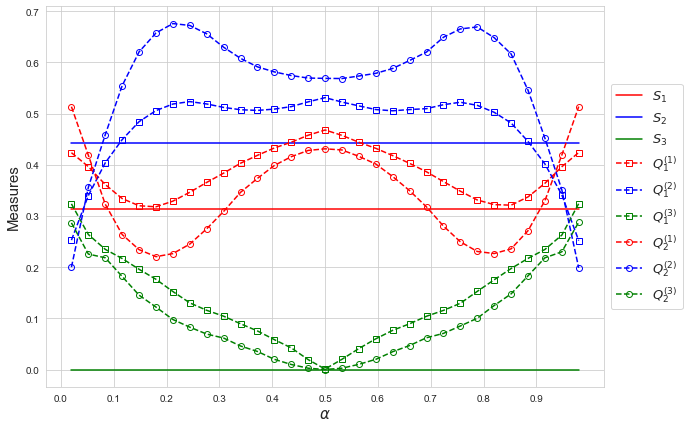

In [610]:
plt.figure(figsize=(10, 7))

plt.plot(alp, S_i_3[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_3[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_3[:, 2], 'g-', label=r'$S_3$')

plt.plot(alp, Q1_alp_3[:, 0], 'rs--',label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_3[:, 1], 'bs--',label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_3[:, 2], 'gs--',label=r'$Q_1^{(3)}$', markerfacecolor='none')


plt.plot(alp, Q2_alp_3[:, 0], 'ro--',label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_3[:, 1], 'bo--',label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_3[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')

plt.xticks(np.arange(0, 1, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

### Test 4: correlated multivariate normal
$Y=x_1 x_3+x_2 x_4$, where$(x_1,x_2,x_3,x_4) \sim N(\mu, \Sigma_x)$ 

#### Objective function

In [611]:
def objfun4(x):
    result = x[:, 0] * x[:, 2] + x[:, 1] * x[:, 3]
    return result

#### Parameters

In [612]:
miu_4 = np.array([0, 0, 250, 400])

cov_4 = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)

# dimension of inputs
dim_4 = np.size(miu_4)

#### pdf of output

In [613]:
# Generate uniform distributed sample
A_4 = np.zeros((N,dim_4)) 
skip = 0
X04 = cp.generate_samples(order=N+skip, domain=dim_4, rule="S").T
X04 = X04[skip:, :dim_4]
 
# transform sample from uniform to multivariate normal
X4 = norm.ppf(X04)
cholesky = np.linalg.cholesky(cov_4)
A_4 = miu_4 + cholesky.dot(X4.T).T

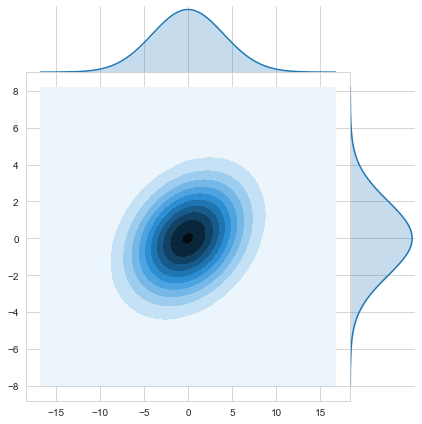

In [614]:
# check the distribution of sample
sns.jointplot(x=A_4[:,0],
              y=A_4[:,1], 
              kind="kde", 
              space=0);

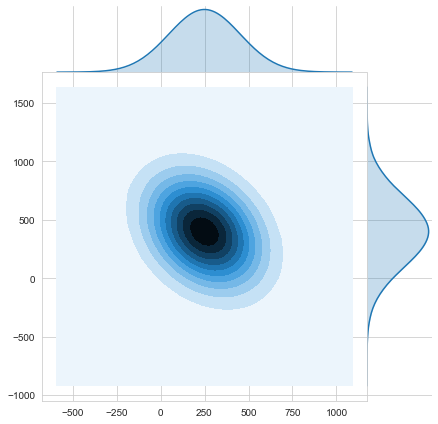

In [615]:
# check the distribution of sample
sns.jointplot(x=A_4[:,2],
              y=A_4[:,3], 
              kind="kde", 
              space=0);

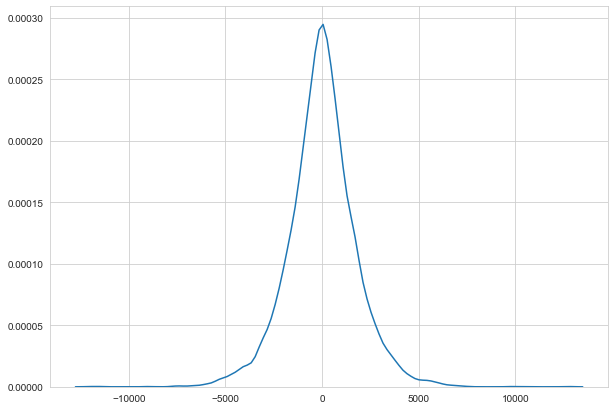

In [616]:
# The PDF of output Y(a)
Y4 = objfun4(A_4)

# fig. 3.(b)
plt.figure(figsize=(10,7))
sns.kdeplot(Y4)

#### Get measures

In [617]:
q1_alp_4, q2_alp_4, Q1_alp_4, Q2_alp_4 = mcs_quantile(objfun4, dim_4, miu_4, cov_4, "Normal")

#### Test

In [619]:
# compare Q2_alp_4 with sobol indice at alpha=0.5(Theorem 1)

# sobol indice given in the paper
S_i_4 = np.array([0.507, 0.399, 0, 0])

# for decimal=1
# assert_almost_equal(Q2_alp_4[15], S_i_4, decimal=1) # pass

# for decimal=2
assert_almost_equal(Q2_alp_4[15], S_i_4, decimal=2)  # fail

AssertionError: 
Arrays are not almost equal to 2 decimals

Mismatch: 50%
Max absolute difference: 0.1113184
Max relative difference: 0.21956291
 x: array([6.18e-01, 3.82e-01, 2.03e-05, 1.43e-05])
 y: array([0.51, 0.4 , 0.  , 0.  ])

#### Fig. 5.  (p42)
Values of $Q_i^{(1)}$ and $Q_i^{(2)}$ (a) $q_i^{(1)}$ and $q_i^{(2)}$ (b) versus $\alpha$ and values of $S_i$ (straight lines). Test 4. ($\rho_{34}=-0.3$)


In [620]:
# for plot convinence
S_i_4 = np.tile(S_i_4, (len(alp), 1))

Text(0, 0.5, 'Measures')

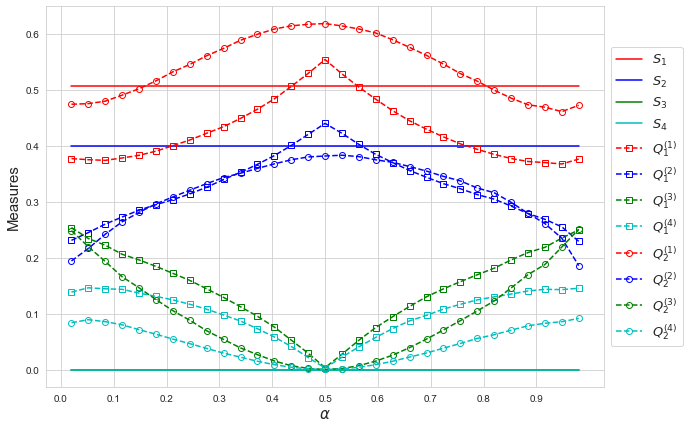

In [621]:
plt.figure(figsize=(10, 7))

plt.plot(alp, S_i_4[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_4[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_4[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_4[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp, Q1_alp_4[:, 0], 'rs--', label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_4[:, 1], 'bs--', label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_4[:, 2], 'gs--', label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_4[:, 3], 'cs--', label=r'$Q_1^{(4)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp_4[:, 0], 'ro--', label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_4[:, 1], 'bo--', label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_4[:, 2], 'go--', label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_4[:, 3], 'co--', label=r'$Q_2^{(4)}$', markerfacecolor='none')


plt.xticks(np.arange(0, 1, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

Text(0.5, 0, '$\\alpha$')

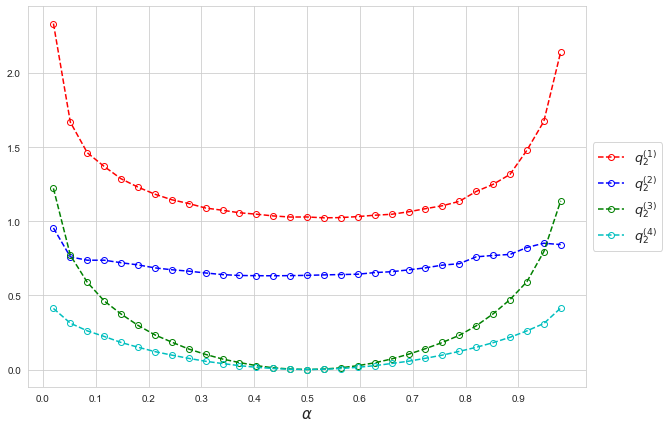

In [622]:
plt.figure(figsize=(10, 7))

plt.plot(alp, q2_alp_4[:, 0]/1000000, 'ro--', label=r'$q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, q2_alp_4[:, 1]/1000000, 'bo--', label=r'$q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, q2_alp_4[:, 2]/1000000, 'go--', label=r'$q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, q2_alp_4[:, 3]/1000000, 'co--', label=r'$q_2^{(4)}$', markerfacecolor='none')

plt.xticks(np.arange(0, 1, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)

## Practical case study(Section 8)

### Case study 1. Roof Truss structure(need check)

#### Objective function

In [51]:
def objfun5(x):
    result = 0.03-(x[:,0]*x[:,1]**2/2*(3.81/(x[:,3]*x[:,5])+1.13/(x[:,2]*x[:,4])))
    return result

#### Parameters

In [55]:
# lower bound for uniform distribution
lower_bound_5 = np.array([20000, 12, 9.82 * 10 ** (-4), 0.04, 2 * 10 ** 11, 3 * 10 ** 10])
# upper bound for uniform distribution
upper_bound_5 = np.array([1400, 0.12, 5.89 * 10 ** (-5), 0.0048,1.2 * 10 ** 10, 1.8 * 10 ** 9])

# dimenion of input|
dim_5 = 6


#### Build base sample

In [56]:
# Generate uniform distributed sample
A_5 = np.zeros((N,dim_5)) 
skip = 0
X05 = cp.generate_samples(order=N+skip, domain=dim_5, rule="S").T
X05 = X05[skip:, :dim_5]
    
A_5 = uniform.ppf(X05,lower_bound_5, upper_bound_5)

#### Get measures

In [59]:
q1_alp_5, q2_alp_5, Q1_alp_5, Q2_alp_5 = mcs_quantile(objfun5, dim_5, lower_bound_5, upper_bound_5, "Uniform")

#### Fig. 7 （p44)
The PDF of output $g(X)$ (a); Values of $Q_i^{(1)}$ and $Q_i^{(2)}$ versus $\alpha$ and values of Sobol’ sensitivity indices (b). Roof truss structure.


Text(0, 0.5, 'Measures')

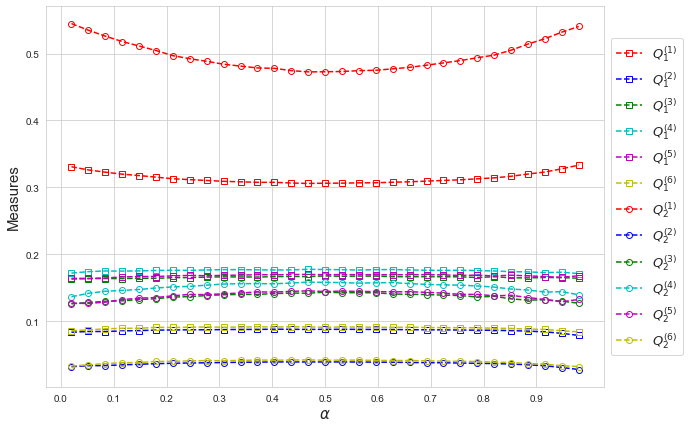

In [60]:
plt.figure(figsize=(10, 7))

plt.plot(alp, Q1_alp_5[:, 0], 'rs--', label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_5[:, 1], 'bs--', label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_5[:, 2], 'gs--', label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_5[:, 3], 'cs--', label=r'$Q_1^{(4)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_5[:, 4], 'ms--', label=r'$Q_1^{(5)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp_5[:, 5], 'ys--', label=r'$Q_1^{(6)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp_5[:, 0], 'ro--', label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_5[:, 1], 'bo--', label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_5[:, 2], 'go--', label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_5[:, 3], 'co--', label=r'$Q_2^{(4)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_5[:, 4], 'mo--', label=r'$Q_2^{(5)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp_5[:, 5], 'yo--', label=r'$Q_2^{(6)}$', markerfacecolor='none')

plt.xticks(np.arange(0, 1, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

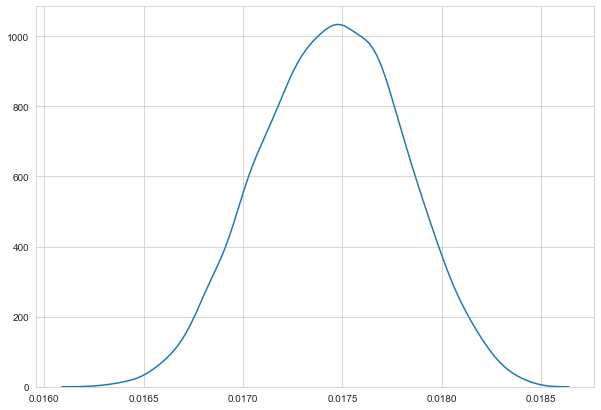

In [61]:
# The PDF of output Y(a)
Y5 = objfun5(A_5)

plt.figure(figsize=(10,7))
sns.kdeplot(Y5)